In [2]:
import dask.array as da
import dcachefs
import fsspec
import jenkspy
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from xrspatial.classify import natural_breaks

from cgc.coclustering import Coclustering
from cgc.utils import calculate_cocluster_averages

# Co-clustering the first-leaf spring index over the conterminous United States

## 1. Introduction

### 1.1 Overview

This notebook illustrates how to use [Clustering Geo-data Cubes (CGC)](https://cgc.readthedocs.io) to perform the co-clustering analysis of a gridded spring-index model that represents the day of first leaf appearance in the conterminous United States for 42 years. The spring index model has been generated using [this notebook](./02-compute-spring-index.ipynb) following the procedure described in [Izquierdo-Veriguier et al., 2018](https://doi.org/10.1016/j.agrformet.2018.06.028) and it is stored on the [SURF dCache storage](http://doc.grid.surfsara.nl/en/stable/Pages/Service/system_specifications/dcache_specs.html).

### 1.2 Co-clustering 

The use of co-clustering overcomes some of the limitations of traditional one-dimensional clustering techniques (such as *k*-means). For spatio-temporal data, traditional clustering  allows the identification of spatial patterns across the full time span of the data, or temporal patterns for the whole spatial domain under consideration. With co-clustering, the space and time dimensions are simultaneously clustered. This allows the creation of groups of elements that behave similarly in both dimensions. These groups are called co-clusters and typically represent a region of the study area that has similar temporal dynamics for a subset of the study period.

### 1.3 The dataset

The data employed in this notebook consists of a spring-index model calculated for the conterminous United States (CONUS) from 1980 to 2021 on a 1-km grid. The data set, which is provided in [Zarr](https://zarr.readthedocs.io/en/stable/) format, includes two spring indices representing the day of the year of first leaf appearance and the day of first bloom. These indices have been computed starting from weather and climate variables from the [Daymet](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840) dataset.

For more information about the data have a look at the original publication: [Izquierdo-Veriguier et al., 2018](https://doi.org/10.1016/j.agrformet.2018.06.028).

### 1.4 Before running this notebook

The input dataset is stored on the SURF dCache system, which we access via bearer-token authentication with a macaroon. The macaroon, generated using [this script](https://github.com/sara-nl/GridScripts/blob/master/get-macaroon), is stored together with other configuration parameters within a JSON fsspec configuration file (also see the [STAC2dCache tutorial](https://github.com/NLeSC-GO-common-infrastructure/stac2dcache/blob/main/notebooks/tutorial.ipynb) and the [fsspec documentation](https://filesystem-spec.readthedocs.io/en/latest/features.html#configuration) for more info):

```json
{
    "dcache": {
        "token": "<MACAROON_STRING_HERE>",
        "api_url": "https://dcacheview.grid.surfsara.nl:22880/api/v1",
        "webdav_url": "https://webdav.grid.surfsara.nl:2880",
        "block_size": 0, 
    "request_kwargs": {
            "timeout": 3600
        }
    }
}
```

## 2. Loading the dataset

### 2.1 Overview

We start by loading the spring index dataset in the distributed memory of a [Dask](https://www.dask.org) cluster and reshape the data so that it is suitable for running the co-clustering analysis. We thus create a combined axis from the "x" and "y" dimensions of the dataset, leading to a two-dimensional ("time", "space") array.

### 2.2 Input parameters

We define the range of years to include in the co-clustering analysis and the path to the Zarr root directory where the dataset is stored.

In [3]:
years = list(range(1980, 2022))

urlpath = (
    "dcache://pnfs/grid.sara.nl/data/remotesensing/disk/spring-index-models.zarr"
)

### 2.2 Opening the dataset

We open the Zarr archive containing the dataset, merging the yearly data in a single array. We open the dataset using the same chunks as employed in the Zarr store. We then select the plant-averaged "first-leaf" spring index. 

In [4]:
fs_map = fsspec.get_mapper(urlpath, block_size=10*2**20)

dss = [
    xr.open_zarr(fs_map, group=year, decode_coords="all", chunks="auto")
    for year in years
]

ds = xr.concat(dss, dim="time")
ds = ds.assign_coords(time=years)
ds

,Array,Chunk
Bytes,22.14 GiB,7.63 MiB
Shape,"(42, 4, 3088, 5727)","(1, 1, 1000, 1000)"
Count,12138 Tasks,4032 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,22.14 GiB,7.63 MiB
Shape,"(42, 4, 3088, 5727)","(1, 1, 1000, 1000)"
Count,12138 Tasks,4032 Chunks
Type,float64,numpy.ndarray


In [5]:
spring_index = ds["first-leaf"].sel(plant="mean")
spring_index

,Array,Chunk
Bytes,5.53 GiB,7.63 MiB
Shape,"(42, 3088, 5727)","(1, 1000, 1000)"
Count,13146 Tasks,1008 Chunks
Type,float64,numpy.ndarray


The spring index is represented as a three-dimensional (time, y, x) array. We can inspect the data set by plotting a slice along the time dimension:

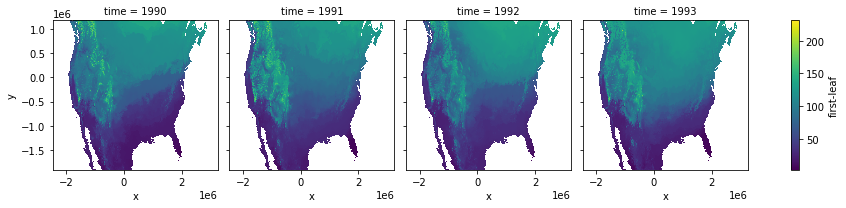

In [6]:
# select years from 1990 to 1993
spring_index.sel(time=slice(1990, 1993)).plot.imshow(col="time")

We manipulate the array spatial dimensions creating a combined (x, y) axis. We also drop the grid cells that have null values for any of the years and rechunk the dataset in order to have data chunks that are homogeneous in size:

In [7]:
spring_index = spring_index.stack(space=["x", "y"])
location = np.arange(spring_index.space.size) # create a combined (x,y) index
spring_index = spring_index.assign_coords(location=("space", location))

# drop pixels that are null-valued for any of the time indices
spring_index = spring_index.dropna("space", how="any")  

# increase the chunk size along the time dimension
spring_index = spring_index.chunk({"time": -1, "space": 500_000})
spring_index

<xarray.DataArray 'first-leaf' (time: 42, space: 10486648)>
dask.array<rechunk-merge, shape=(42, 10486648), dtype=float64, chunksize=(42, 500000), chunktype=numpy.ndarray>
Coordinates:
    lambert_conformal_conic  int16 -32767
    plant                    <U4 'mean'
  * time                     (time) int64 1980 1981 1982 1983 ... 2019 2020 2021
  * space                    (space) object MultiIndex
  * x                        (space) float64 -1.951e+06 -1.951e+06 ... 2.965e+06
  * y                        (space) float64 5.2e+04 5.1e+04 ... 8.94e+05
    location                 (space) int64 dask.array<chunksize=(500000,), meta=np.ndarray>

In [8]:
# print size of the matrix
print("{} MB".format(spring_index.nbytes/2**20))

3360.2845458984375 MB


### 2.3 Loading the data

Once the data is correctly reshaped we setup a Dask cluster (e.g. via the Dask JupyterLab extension) and create a client connection.

In [1]:
from dask.distributed import Client

client = Client("tcp://10.0.1.204:34375")
client

Connection method: Direct,
Dashboard: /proxy/8787/status,
Comm: tcp://10.0.1.204:34375,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


Here we have created a cluster with 20 nodes. When the nodes are ready, we load the data in the distributed memory of the cluster:

In [9]:
client.wait_for_workers(n_workers=20)
spring_index = spring_index.persist()

## 3. The co-clustering analysis

### 3.1 Overview

Once we have loaded the data set as a 2D array, we can run the co-clustering analysis. We use the Jenks natural breaks algorithm on the time-averaged spring index to identify suitable initial conditions for the space clusters (the time clusters are instead randomly initialized). The algorithm implemented in CGC iteratively updates the co-clusters until the loss function that corresponds to the information loss in each cluster does not significantly change in two consecutive iterations (a threshold is provided). The solution reached by the algorithm does not necessarily represent the global minimum of the loss function (it might be a local minimum). Thus, multiple differently-initialized runs need to be performed in order to sample the cluster space, and the cluster assignment with the lowest loss-function value selected as best candidate solution. For more information about CGC, have a look at the package [documentation](https://cgc.readthedocs.io/en/latest/user_manual.html#co-clustering) or at [this article](https://doi.org/10.21105/joss.04032).

### 3.2 Input parameters and configuration

To run the co-clustering analysis for the first-leaf spring index that we have loaded in the previous section, we first have to choose an initial number of spatial and temporal clusters and set the values of few other parameters:

In [10]:
num_time_clusters = 5
num_space_clusters = 100

max_iterations = 2000  # maximum number of iterations
conv_threshold = 1.  # convergence threshold 
nruns = 10  # number of differently-initialized runs

CGC makes use of `logging`, we set the desired verbosity via:

In [11]:
logging.basicConfig(level=logging.INFO)

### 3.3 Initial conditions



Initial conditions can significantly affect the convergence of the co-clustering analysis. Here we use the [Jenks natural breaks](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization)  classification methods on a sample of the time-averaged spring index to compute an initial cluster assignment in the spatial domain. Initial conditions for the time clusters are not provided, thus CGC initializes these randomly. For this reason, multiple runs with different (time) cluster initialization need to be computed in order to make sure we get as close as possible to the global optimum.     

In [12]:
# calculate time-averaged spring index
spring_index_mean = spring_index.mean(dim="time")
spring_index_mean = spring_index_mean.compute()

In [13]:
%%time 
nb_labels = natural_breaks(
    spring_index_mean.unstack("space"), 
    num_sample=20_000, 
    k=num_space_clusters,
)

CPU times: user 26 s, sys: 391 ms, total: 26.4 s
Wall time: 26.2 s


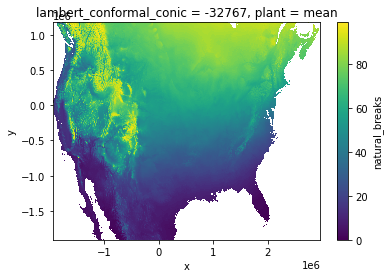

In [14]:
# plot initial space cluster labels
nb_labels.plot.imshow(x="x", y="y")

In [15]:
# as for the dataset, create combined x,y dim and drop NaN's
space_clusters_init = nb_labels \
    .stack(space=["x", "y"]) \
    .dropna("space", how="any") \
    .astype("int") 

# set the same chunking as for the dataset
space_clusters_init = space_clusters_init.chunk({"space": 500_000})

In [16]:
# load initial conditions in the distributed memory
space_clusters_init = space_clusters_init.persist()

### 3.4 Running the analysis

We are now ready to run the analysis. CGC offers multiple implementations of the same co-clustering algorithm. Ultimately, the most suitable implementation for a given problem is determined by the size of the data set of interest and by the infrastructure that is available for the analysis. Here we make use of a Dask-based co-clustering implementation that exploits parallelization for both the data chunks and the co-clustering runs.

We start by initializing a `Coclustering` object:

In [17]:
cc = Coclustering(
    spring_index.data,  # data array (must be 2D)
    num_time_clusters,  # number of row clusters
    num_space_clusters,  # number of column clusters 
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    col_clusters_init=space_clusters_init.data,
    nruns=nruns,
)

To start the co-clustering runs, we now pass the instance of the client connection to the Dask cluster to the `run_with_dask` method:

In [18]:
%%time
results = cc.run_with_dask(client=client, low_memory=False)

INFO:cgc.coclustering:Retrieving run 0 ..
INFO:cgc.coclustering:Error = -127058010783.72952
INFO:cgc.coclustering:Run converged in 595 iterations
INFO:cgc.coclustering:Retrieving run 1 ..
INFO:cgc.coclustering:Error = -127057871818.3171
INFO:cgc.coclustering:Run converged in 749 iterations
INFO:cgc.coclustering:Retrieving run 2 ..
INFO:cgc.coclustering:Error = -127058654795.42297
INFO:cgc.coclustering:Run converged in 753 iterations
INFO:cgc.coclustering:Retrieving run 3 ..
INFO:cgc.coclustering:Error = -127059830157.6056
INFO:cgc.coclustering:Run converged in 903 iterations
INFO:cgc.coclustering:Retrieving run 4 ..
INFO:cgc.coclustering:Error = -127061883558.32326
INFO:cgc.coclustering:Run converged in 988 iterations
INFO:cgc.coclustering:Retrieving run 5 ..
INFO:cgc.coclustering:Error = -127051381528.46564
INFO:cgc.coclustering:Run converged in 1034 iterations
INFO:cgc.coclustering:Retrieving run 6 ..
INFO:cgc.coclustering:Error = -127049830276.2116
INFO:cgc.coclustering:Run converge

CPU times: user 40.4 s, sys: 4.47 s, total: 44.8 s
Wall time: 3h 32min 13s


## 4. Inspecting the results 

The object returned by the `run_with_dask` method contains all the co-clustering results, the most relevant being the row (temporal) and column (spatial) cluster assignments:

In [20]:
print(f"Row (time) clusters: {results.row_clusters}")
print(f"Column (space) clusters: {results.col_clusters}")

Row (time) clusters: [0 3 0 0 0 0 2 4 3 1 2 4 3 0 3 3 1 1 4 2 2 0 1 3 3 2 2 3 0 1 4 0 2 1 0 3 3
 2 1 1 1 4]
Column (space) clusters: [ 9 13 13 ... 80 80 80]


The integers contained in these arrays represent the cluster labels for each of the two dimensions. They allow to identify the co-cluster to which each element belongs: the (i, j) element of the spring index matrix belongs to the co-cluster (m, n), where m and n are the i-th element of `results.row_clusters` and j-th element of `results.col_clusters`, respectively. 

To facilitate plotting, we create `DataArray`'s for the spatial and temporal cluster labels: 

In [21]:
time_clusters = xr.DataArray(results.row_clusters, 
                             dims='time', 
                             coords=spring_index.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(results.col_clusters, 
                              dims='space', 
                              coords=spring_index.space.coords, 
                              name='space cluster')

We can now visualize the temporal clusters to which each year belongs, and make a histogram of the number of years in each cluster:

(array([10.,  9.,  8., 10.,  5.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

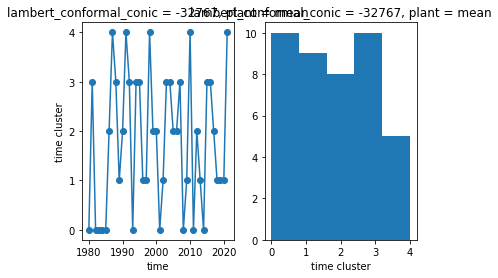

In [22]:
fig, ax = plt.subplots(1, 2)

# line plot
time_clusters.plot(ax=ax[0], x='time', marker='o')
ax[0].set_yticks(range(num_time_clusters))

# temporal cluster histogram
time_clusters.plot.hist(ax=ax[1], bins=num_time_clusters)

Spatial clusters can also be visualized after 'unstacking' the location index that we have initially created, thus reverting to the original (x, y) coordinates:

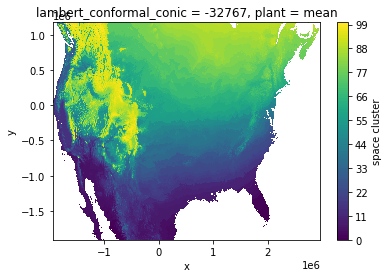

In [23]:
space_clusters_xy = space_clusters.unstack('space')
space_clusters_xy.plot.imshow(
    x='x', y='y', levels=range(num_space_clusters+1)
)

The average spring index value of each co-cluster can be computed via a dedicated utility function in CGC, which return the cluster means in a 2D-array with dimensions `(n_row_clusters, n_col_clusters)`. We calculate the cluster averages and create a `DataArray` for further manipulation and plotting:

In [24]:
# calculate the co-cluster averages
means = calculate_cocluster_averages(
    spring_index.data, 
    time_clusters, 
    space_clusters, 
    num_time_clusters, 
    num_space_clusters
)
means = xr.DataArray(
    means,
    coords=(
        ('time_clusters', range(num_time_clusters)), 
        ('space_clusters', range(num_space_clusters))
    )
)

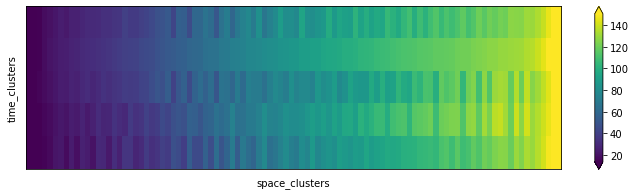

In [29]:
# drop co-clusters that are not populated 
means = means.dropna('time_clusters', how='all')
means = means.dropna('space_clusters', how='all')

# use first row- and column-clusters to sort 
space_cluster_order = means.isel(time_clusters=0)
time_cluster_order = means.isel(space_clusters=0)
means_sorted = means.sortby(
    [space_cluster_order, time_cluster_order]
)
# drop labels, no longer needed
means_sorted = means_sorted.drop_vars(['time_clusters', 'space_clusters'])

# now plot the sorted co-cluster means 
means_sorted.plot.imshow(
    xticks=[], yticks=[],
    robust=True,
    aspect=4,
    size=3,
)

The computed co-cluster means and the spatial clusters can be employed to plot the average first-leaf value for each of the temporal clusters: 

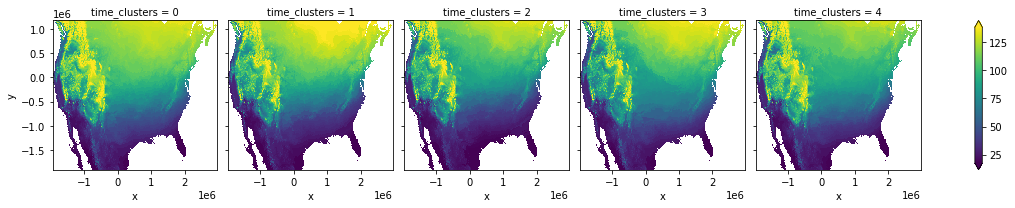

In [30]:
space_means = means.sel(space_clusters=space_clusters, drop=True)
space_means = space_means.unstack('space')
space_means.plot.imshow(
    x='x', y='y', col='time_clusters',
    robust=True
)

When we are done with calculations, we shutdown the cluster to release resources:

In [31]:
client.shutdown()